## 127 - Chi-Square Test

### Chi-Square Test: A Resampling Approach

In [5]:
from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

In [354]:
click_rate = pd.read_csv("click_rates.csv")

clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
print(clicks)

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [356]:
print("We pivot the table, from:\n")
print(click_rate)

print("\nto:\n")

print(clicks)


We pivot the table, from:

     Headline     Click  Rate
0  Headline A     Click    14
1  Headline A  No-click   986
2  Headline B     Click     8
3  Headline B  No-click   992
4  Headline C     Click    12
5  Headline C  No-click   988

to:

Headline  Headline A  Headline B  Headline C
Click                                       
Click             14           8          12
No-click         986         992         988


In [358]:
# Counting how many clicks and no-clicks we have:
successes = clicks.sum(axis='columns')
tot_clicks =  successes.iloc[0]
tot_no_clicks = successes.iloc[1]

print ("Tot Clicks:", tot_clicks)
print ("Tot No-Clicks:", tot_no_clicks)

Tot Clicks: 34
Tot No-Clicks: 2966


### The resampling approach:

Resampling method to calculate a chi-square test's p-value. This is a powerful technique in statistics that helps us understand if observed differences are statistically significant.

In [441]:
# Resampling approach

    # "box" is a long list of 34x "1s" and 2966x "0s" (3000 items in total, to mimic our "clicks" data)
box = [1] * tot_clicks
box.extend([0] * tot_no_clicks)
    # The shuffling randomizes their order.
random.shuffle(box)


# Chi-square Function definition ----------------------------------------------------------------------------

    # This function implements the standard chi-square formula: Σ((O-E)²/E), where:
    # - O is the observed value
    # - E is the expected value (calculated below)
    # - We square the differences and divide by the expected value
    # - Finally, we sum all these terms

    # The function implements Pearson's chi-square test statistic, which measures how different our observed values are 
    # from what we expected. Like measuring the "distance" between reality and our expectations.
 
def chi2(observed, expected):
    pearson_residuals = []
    
    # The outer loop for "row, expect in zip(observed, expected)" pairs each row of observations with its expected value:
    
    for row, expect in zip(observed, expected):
    
        # For each pair, the list comprehension "[(observe - expect) ** 2 / expect for observe in row]"
        #calculates the Pearson residual for each observation.

        # Throughout the loop, "row" assumes values like [14  8 12], [986 992 988], [9, 9, 16]
        # While "expect" assumes 11.334 or 988.667 depending on whether it's a "click" or "no-click" row
        # So this function compares the observed to the expected, calculates the difference, squares it and divides by the expected
        # Following the standard chi-square formula: Σ( (O-E)²/E )
        # and appends it to "pearson_residuals" list, and sum all the values at the end, and returns this Σ.

        # These calculations measure how far each observed value is from its expectation, squared and scaled by the expected value. 
        # The squaring makes all differences positive and emphasizes larger deviations.
 
        pearson_residuals.append(  [(observe - expect) ** 2 / expect for observe in row]   )

    
      
    # return sum of squares
    # "np.sum(pearson_residuals)" adds up all these individual terms to give us our chi-square statistic. 
    # A larger value indicates stronger evidence against the null hypothesis (the idea that any differences are due to chance).
    # To help visualize this, imagine you're measuring the "surprise factor" of your data. 
    # Each term (O-E)²/E represents how surprised you are by a particular observation
    # - If observed ≈ expected, you get a small number (not surprising)
    # - If observed is very different from expected, you get a large number (very surprising)
    # - The final sum tells you how surprised you are by the entire dataset
    
    return np.sum(pearson_residuals)


## END Chi-square Function definition ----------------------------------------------------------------------------  


    # The expected values are calculated:
    # All values divided by 3 as we expect equal distribution across 3 groups
    # Under the null hypothesis, we'd expect the 34 successes to be equally distributed across the three groups (about 11.33 per group).

expected_clicks = tot_clicks / 3
expected_noclicks = tot_no_clicks / 3
expected = [expected_clicks, expected_noclicks]


    # Here we apply the Chi-square function to calculate the observed value:

chi2observed = chi2(clicks.values, expected)


# Permutation Function ----------------------------------------------------------------------------

def perm_fun(box):

    # Reshuffles the box (simulating the null hypothesis where group assignment is random)
    random.shuffle(box)

    # Splits it into three groups of 1000 and
    # Counts successes (clicks) in each group
    
    sample_clicks = [sum(box[0:1000]),
                     sum(box[1000:2000]),
                     sum(box[2000:3000])]

    
    # The list "sample_clicks" looks like "[9, 10, 15], [10, 7, 17], [16, 9, 9], ... "

    # Calculates non-successes (no-clicks)
    sample_noclicks = [1000 - n for n in sample_clicks]

    # Computes the chi-square statistic for this random arrangement
    return chi2([sample_clicks, sample_noclicks], expected)

# END Permutation Function ----------------------------------------------------------------------------


    # Executes permutation function "perm_fun" 2000 times
    # return the 2000 chi-square statistic values each time, and stores in the list "perm_chi2"

perm_chi2 = [perm_fun(box) for _ in range(2000)]


    # The p-value is the proportion of permuted chi-square values that exceed the observed value:
    # so we compare "perm_chi2" (each of the 2000 of them) to "chi2observed", and if it's greater, we count it as "1", 
    # and we do it for each of the 2000 values. Then we count how many of those 2000 resamplings gave us perm_chi2 > chi2observed 
    # (by summing the 1s), and divide by the number of resamplings (2000) to calculate the proportion. This is the p-value.

    # This tells us how likely we would be to see our observed difference (or something more extreme) if the null hypothesis were true.

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)

    # We print the values:
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampling p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampling p-value: 0.4420


##  Visualization of chi-square probability density functions


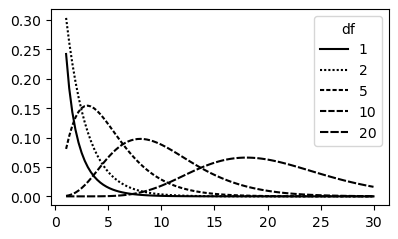

In [241]:
# This code creates a visualization of chi-square probability density functions (PDFs) with different degrees of freedom. 

    # This creates 100 evenly spaced points between 1 and 30. Think of it as creating a ruler with 100 marks 
    # that we'll use them to generate y values and to plot our distributions.
x = [1 + i * (30 - 1) / 99 for i in range(100)]

    # This code creates a DataFrame containing the chi-square PDFs:

    # For each x-value, it calculates the probability density for chi-square distributions with different 
    # degrees of freedom (df): 1, 2, 5, 10, and 20. 
    # Each "df" represents how many independent squared standard normal variables were added together to create that distribution.

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})

# The plotting code creates a figure showing the distributions:
    # We plot the points chi.x (xs) and chi.chi_"df" (ys)

fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='black', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='black', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='black', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='black', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='black', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()

In [443]:
# Here is what the "chi" dataframe looks like
chi.head()

,x,chi_1,chi_2,chi_5,chi_10,chi_20
0,1.000000,0.241971,0.303265,0.080657,0.000790,1.632262e-09
1,1.292929,0.183809,0.261947,0.102422,0.001906,1.423488e-08
2,1.585859,0.143355,0.226259,0.120177,0.003727,7.725957e-08
3,1.878788,0.113762,0.195432,0.133854,0.006341,3.068055e-07
4,2.171717,0.091396,0.168806,0.143685,0.009778,9.763016e-07


### Chi-square using formula


In [446]:
import numpy as np
from scipy import stats

# Data Organization --------------------------------------------------------------------------------------
#We arrange our data in a contingency table format (2x3):

    # Rows: clicks vs no-clicks
    # Columns: the three groups
    # This organization helps us see the structure of our data clearly
    
    
    # Let's organize our data first
    # Assuming we had:
    # - 34 total clicks across 3000 attempts (1000 per group)
    # - The clicks were distributed as: 15, 10, and 9 clicks in the three groups
    
    # Observed values
observed_clicks = np.array([14, 8, 12])  # array of clicks in each group
observed_no_clicks = 1000 - observed_clicks  # array of no-clicks in each group

    # Stack these into a 2x3 array (rows: clicks/no-clicks, columns: groups)
observed = np.vstack([observed_clicks, observed_no_clicks])



# Expected Values --------------------------------------------------------------------------------------
# Under the null hypothesis (no difference between groups):

    #We expect clicks to be evenly distributed (34/3 ≈ 11.33 per group)
    #No-clicks are just the complement (1000 - 11.33 per group)
    #These represent what we'd expect if group assignment had no effect

    # Calculate expected values
total_clicks = tot_clicks
total_per_group = 1000
n_groups = 3

    # Under null hypothesis, expect equal distribution of clicks across groups

expected_clicks = total_clicks / n_groups  # about 11.33 clicks per group
expected_no_clicks = total_per_group - expected_clicks  # about 988.67 no-clicks per group


# Create expected values array matching shape of observed
expected_formula = np.array([[expected_clicks] * n_groups, 
                             [expected_no_clicks] * n_groups])

# Calculate chi-squared statistic manually
chi_squared = np.sum((observed - expected_formula)**2 / expected_formula)


# Calculate degrees of freedom --------------------------------------------------------------------------------------
    # For a contingency table, df = (rows-1) × (columns-1)
    # In our case: (2-1) × (3-1) = 2
    # This accounts for the constraints in our data

df = (observed.shape[0] - 1) * (observed.shape[1] - 1)


# P-value Calculation --------------------------------------------------------------------------------------
    # We use the chi-square distribution with 2 df
    # The p-value is the area in the right tail beyond our chi-square statistic
    # A small p-value (< 0.05) would suggest the differences aren't due to chance 

p_value = 1 - stats.chi2.cdf(chi_squared, df)

    # The key advantage of this formula approach is its theoretical foundation and computational efficiency. 
    # However, the resampling approach we saw earlier has its own benefits:
    # - It makes fewer assumptions about the underlying distribution
    # - It can handle small expected frequencies better
    # - It gives us a more intuitive understanding of the null hypothesis

print(f'Chi-squared statistic: {chi_squared:.4f}')
print(f'Degrees of freedom: {df}')
print(f'P-value: {p_value:.4f}')

Chi-squared statistic: 1.6659
Degrees of freedom: 2
P-value: 0.4348


### More detail on "p_value = 1 - stats.chi2.cdf(chi_squared, df)"

Think of the chi-square distribution as a mathematical curve that shows all possible chi-square values and their probabilities. When we calculate our chi-square statistic (in our case, by summing all the (O-E)²/E terms), we get a single point on this curve.

The p-value tells us: "If the null hypothesis were true (no real differences between groups), what's the probability of seeing a chi-square value as extreme as, or more extreme than, what we observed?"


Let's understand what "stats.chi2.cdf(chi_squared, df)" does:

cdf stands for Cumulative Distribution Function

For any value x, the CDF tells us the probability of getting a chi-square value less than or equal to x

The df parameter shapes the distribution based on our degrees of freedom

--------------------------------------
#### So why do we subtract from 1?

Imagine our calculated chi-square statistic is 7.5. The CDF would give us the probability of getting a value less than 7.5. 

But for our p-value, we want the opposite: the probability of getting a value greater than 7.5. 

Since all probabilities must sum to 1, we can subtract the CDF from 1 to get this "tail probability."

Think of it like this: if you have a ruler marked from 0 to ∞, and you've found your chi-square value on that ruler:


#### CDF
The CDF tells you "what fraction of the distribution lies to the left of your mark"
Subtracting from 1 gives you "what fraction lies to the right"
This right-hand fraction is your p-value

The reason we care about the right tail is that larger chi-square values indicate stronger evidence against the null hypothesis. Our p-value tells us how unusual our result would be if the null hypothesis were true.
As practical interpretation:

- If p < 0.05: We typically consider this "statistically significant"
- If p > 0.05: We don't have strong evidence against the null hypothesis
- The smaller the p-value, the stronger the evidence against the null hypothesis



## Visualization

This code creates a visualization that shows several important elements:

- The blue curve represents the chi-square distribution with our specified degrees of freedom
- The red dashed line shows our test statistic (7.5 in this example)
- The light blue area shows the probability of values less than our test statistic
- The red shaded area represents our p-value - the probability of getting a value as extreme as or more extreme than our test statistic

To use this code with different values, you can simply change the chi_squared_value and df parameters. For example, if you wanted to see how it looks with different degrees of freedom or a different test statistic:

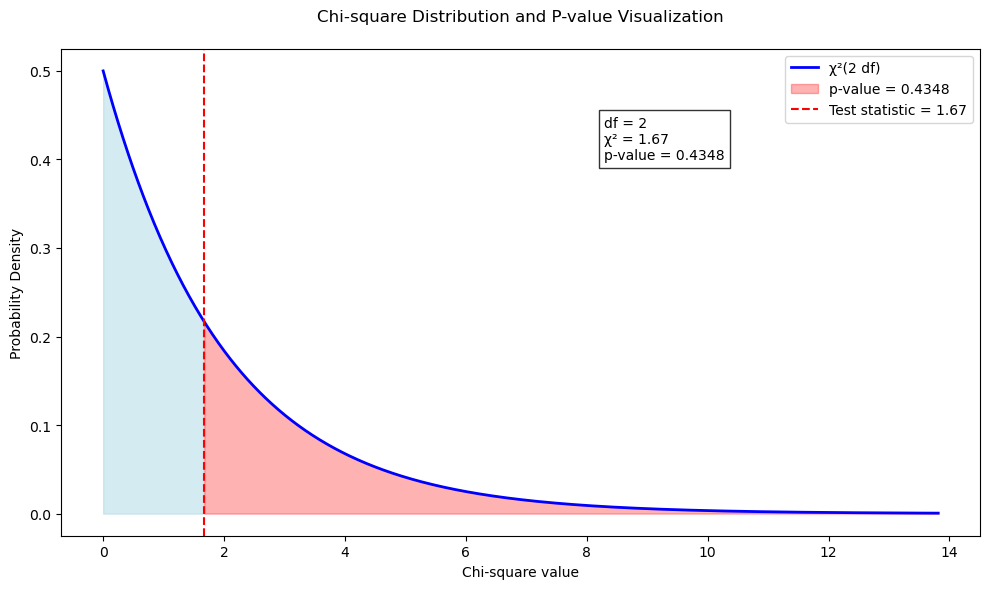

In [439]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Chi-Square Plot Function Definition ----------------------------------------------------------------------------------------------------

def plot_chi_square_test(chi_squared_value, df, figsize=(10, 6)):
    """
    Create a visualization of chi-square distribution showing test statistic and p-value.
    
    Parameters:
    chi_squared_value: The calculated chi-square test statistic
    df: Degrees of freedom for the chi-square distribution
    figsize: Size of the figure (width, height)
    """
    
    # Create the figure and axis
    plt.figure(figsize=figsize)
    
    # Generate x values for plotting
    # We'll go up to a value that captures most of the distribution
    x = np.linspace(0, max(chi_squared_value * 2, stats.chi2.ppf(0.999, df)), 1000)
    
    # Calculate the chi-square distribution
    chi_square_dist = stats.chi2.pdf(x, df)
    
    # Calculate p-value
    p_value = 1 - stats.chi2.cdf(chi_squared_value, df)
    
    # Create the main plot
    plt.plot(x, chi_square_dist, 'b-', lw=2, label=f'χ²({df} df)')
    
    # Fill the areas for visual understanding
    # Area left of test statistic
    plt.fill_between(x[x <= chi_squared_value], chi_square_dist[x <= chi_squared_value], 
                     color='lightblue', alpha=0.5)
    
    # Area right of test statistic (p-value)
    plt.fill_between(x[x >= chi_squared_value], chi_square_dist[x >= chi_squared_value],
                     color='red', alpha=0.3, label=f'p-value = {p_value:.4f}')
    
    # Add vertical line for test statistic
    plt.axvline(x=chi_squared_value, color='r', linestyle='--', 
                label=f'Test statistic = {chi_squared_value:.2f}')
    
    # Customize the plot
    plt.title('Chi-square Distribution and P-value Visualization', pad=20)
    plt.xlabel('Chi-square value')
    plt.ylabel('Probability Density')
    
    # Add explanatory text
    text_x = max(x) * 0.6
    text_y = max(chi_square_dist) * 0.8
    plt.text(text_x, text_y, 
             f'df = {df}\nχ² = {chi_squared_value:.2f}\np-value = {p_value:.4f}',
             bbox=dict(facecolor='white', alpha=0.8))
    
    # Add legend
    plt.legend()
    
    # Ensure all elements are visible
    plt.tight_layout()
    
    return plt

# Example usage with our previous chi-square test values
chi_squared_value = chi_squared  # Our test statistic from the previous exercise
df = 2                  # Degrees of freedom, from the previous exercise

# Create and display the plot
plot = plot_chi_square_test(chi_squared_value, df)
plt.show()

In [437]:
chi_squared

1.6659394708658917

### Fisher's Exact Test

Scipy has only an implementation of Fisher's Exact test for 2x2 matrices. There is a github repository that provides a Python implementation that uses the same code as the R version. Installing this requires a Fortran compiler.

stats.fisher_exact(clicks)

BUT: The input `table` must be of shape (2, 2).
There is no implementation of Fisher’s exact test easily available in Python.

